In [3]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf
import pickle as pk
import dill
import collections

from joblib import Parallel, delayed
import os

In [5]:
rna = ad.read_h5ad("/mnt/isilon/cscb/Projects/10x/pillaiv/SCTC-VP-22/vinodh-5-3-integration/processed/02-annotation/for_maxfuse_integrated.h5ad")

In [82]:
sc.pp.scale(rna)

In [6]:
codex = ad.read_h5ad("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/MCD1_reg1/gated_dat.h5ad")
codex_names = codex.var_names
cvrt_names = codex_names[~codex_names.isin(rna.var_names)]
ag_names = pd.DataFrame({"codex":codex.var_names,
                        "rna":codex.var_names})
cvrt_names_codex = ['DAPI', 'CD123', 'BCL-6', 'Ki67', 'CD25', 'Tryptase', 'CD11c',
       'Collagen IV', 'PD-1', 'CD1c', 'BCL-2', 'CD134', 'CD35', 'CD11b',
       'CD30', 'Podoplanin', 'HLA-DR', 'CD20', 'CD8', 'CD138', 'CD23',
       'Fascin', 'CD45', 'CD45RA', 'Mac2Gal3', 'Granzyme B', 'CD21', 'CD3e',
       'aSMA', 'CD31', 'CD15', "MX-1"]
cvrt_names_rna = ['NA', 'IL3RA', 'BCL6', 'MKI67', 'IL2RA', 'TPSAB1', 'ITGAX', 'COL4A1', 
                  'PDCD1', 'CD1C', 'BCL2', 'TNFRSF4', 'CR1', 'ITGAM', 'TNFRSF8', 'PDPN', 'HLA-DRB1', 
                  'MS4A1', 'CD8A', 'SDC1', 'FCER2', 'FSCN1', 'PTPRC', 'NA', 'LGALS3', 'GZMB', 'CR2', 
                  'CD3E', 'ACTA1', 'PECAM1', 'FUT4', 'MX1']
ag_names.loc[ag_names.codex.isin(cvrt_names_codex),'rna'] = cvrt_names_rna

In [58]:
def nameConverter(rna, codex):
    codex_names = codex.var_names
    # cvrt_names = codex_names[~codex_names.isin(rna.var_names)]
    cvrt_names_codex = ['DAPI', 'CD123', 'BCL-6', 'Ki67', 'CD25', 'Tryptase', 'CD11c',
           'Collagen IV', 'PD-1', 'CD1c', 'BCL-2', 'CD134', 'CD35', 'CD11b',
           'CD30', 'Podoplanin', 'HLA-DR', 'CD20', 'CD8', 'CD138', 'CD23',
           'Fascin', 'CD45', 'CD45RA', 'Mac2Gal3', 'Granzyme B', 'CD21', 'CD3e',
           'aSMA', 'CD31', 'CD15', "MX-1"]
    cvrt_names_rna = ['NA', 'IL3RA', 'BCL6', 'MKI67', 'IL2RA', 'TPSAB1', 'ITGAX', 'COL4A1', 
                      'PDCD1', 'CD1C', 'BCL2', 'TNFRSF4', 'CR1', 'ITGAM', 'TNFRSF8', 'PDPN', 'HLA-DRB1', 
                      'MS4A1', 'CD8A', 'SDC1', 'FCER2', 'FSCN1', 'PTPRC', 'NA', 'LGALS3', 'GZMB', 'CR2', 
                      'CD3E', 'ACTA1', 'PECAM1', 'FUT4', 'MX1']
    cvrt_names = list(set(cvrt_names_codex).union(codex_names))
    ag_names = pd.DataFrame({"codex":cvrt_names,
                            "rna":cvrt_names})
    ag_names.set_index('codex', inplace=True, drop=False)
    ag_names.loc[cvrt_names_codex,'rna'] = cvrt_names_rna
    ag_names = ag_names.loc[codex_names,:]
    return ag_names

In [86]:
def batch_maxfuse(sname, rna=rna):
    fname = os.path.join("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis",sname,"gated_dat.h5ad")
    codex = ad.read_h5ad(fname)
    ag_names = nameConverter(rna, codex)
    sc.pp.scale(codex)
    # pre-processing steps
    keep = ag_names.rna[ag_names.rna.isin(rna.var_names)]
    rna_shared = rna[:, keep.tolist()].copy()
    keep = ag_names.codex[ag_names.rna.isin(rna_shared.var_names)]
    protein_shared = codex[:, keep.tolist()].copy()
    # sc.pp.scale(protein_shared)
    rna_shared = rna_shared.X.copy()
    protein_shared = protein_shared.X.copy()
    # sc.pp.scale(codex)
    rna_active = rna.X
    protein_active = codex.X

    # MaxFuse
    fusor = mf.model.Fusor(
        shared_arr1=rna_shared,
        shared_arr2=protein_shared,
        active_arr1=rna_active,
        active_arr2=protein_active,
        labels1=None,
        labels2=None
    )
    fusor.split_into_batches(
        max_outward_size=35000,
        matching_ratio=4,
        metacell_size=2,
        verbose=True)
    fusor.construct_graphs(
        n_neighbors1=15,
        n_neighbors2=15,
        svd_components1=35,
        svd_components2=35,
        resolution1=1.5,
        resolution2=1.5,
        # if two resolutions differ less than resolution_tol
        # then we do not distinguish between then
        resolution_tol=0.1,
        verbose=True
    )
    fusor.find_initial_pivots(
        wt1=0.3, wt2=0.3,
        svd_components1=13, svd_components2=13
    )
    fusor.refine_pivots(
        wt1=0.3, wt2=0.3,
        svd_components1=35, svd_components2=None,
        cca_components=25,
        n_iters=1,
        randomized_svd=False, 
        svd_runs=1,
        verbose=True
    )
    fusor.filter_bad_matches(target='pivot', filter_prop=0.3)
    pivot_matching = fusor.get_matching(order=(2, 1),target='pivot')
    labels_rna = rna.obs.pred_anno_2.to_numpy()
    labels_codex = codex.obs.new_pheno.to_numpy()
    fusor.propagate(
        svd_components1=35, 
        svd_components2=None, 
        wt1=0.7,
        wt2=0.7,
    )
    fusor.filter_bad_matches(
        target='propagated',
        filter_prop=0.3
    )
    full_matching = fusor.get_matching(order=(2, 1), target='full_data')

    # save the results
    with open("maxfuse_out/"+sname+"_fuseResult.pk", "wb") as f:
        pk.dump(full_matching, f)
    
    return None
    

In [87]:
codex_data = [s for s in os.listdir("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/") if 'reg' in s and 'K' not in s]

In [88]:
res = Parallel(8)(delayed(batch_maxfuse)(s) for s in codex_data)

The first data is split into 1 batches, average batch size is 50117, and max batch size is 50117.
The second data is split into 1 batches, average batch size is 74655, and max batch size is 74655.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
The first data is split into 1 batches, average batch size is 50117, and max batch size is 50117.
The second data is split into 1 batches, average batch size is 117595, and max batch size is 117595.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
The first data is split into 1 batches, average batch size is 50117, and max batch size is 50117.
The second data is split into 1 batches, average batch size is 90055, and max batch size is 90055.
Batch to batch correspondence is:
  ['0<->0']

/home/smithd30/miniconda3/envs/maxfuse/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The first data is split into 1 batches, average batch size is 50117, and max batch size is 50117.
The second data is split into 1 batches, average batch size is 180228, and max batch size is 180228.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Done!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Done!
Now at batch 0<->0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Done!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Metacell clustering fin

/home/smithd30/miniconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/smithd30/miniconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


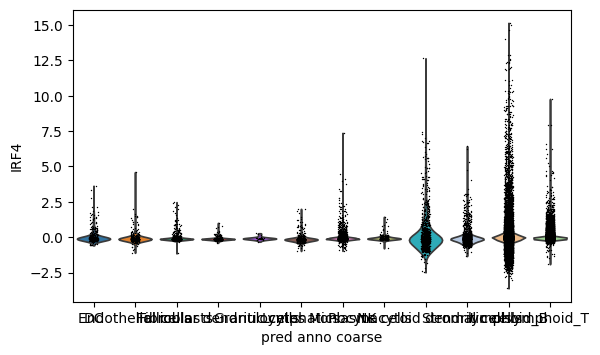

In [20]:
sc.pl.violin(rna, ["IRF4"], groupby="pred_anno_coarse", use_raw=False)

In [18]:
rna.var_names

Index(['CEMIP', 'BANK1', 'AFF3', 'IGHG4', 'BACH2', 'IGHG3', 'TIMP3', 'IGLC1',
       'SLC8A1', 'IGKC',
       ...
       'CERS2', 'CA8', 'ECI2', 'PDK1', 'EI24', 'GTF2IRD2B', 'FHOD1', 'CTDSP1',
       'MAFK', 'U2AF1L4'],
      dtype='object', length=2000)

In [19]:
ag_names.rna[ag_names.rna.isin(rna.var_names)]

1         IRF4
3         IRF8
4         TCF4
6         BCL6
9        IL2RA
12       ITGAX
13      COL4A1
16        BCL2
19         CR1
21        ICOS
25        CD38
27    HLA-DRB1
28       MS4A1
33       PTPRC
38         CR2
42      PECAM1
Name: rna, dtype: object